# **C3 Assignment**
## Agent-Powered Business Assistant

**Omar Ramadan (AUB ID: 202204622)** — *EECE 798S: Agentic Systems*

The goal of this assignment is to design an intelligent and interactive chatbot representing a fictuous business and capable of answering user questions, collecting customer leads, and recording feedback through tool-based actions.

For my submission, I will be using the Gemini API (which is free for limited usage) for conversational intelligence and Gradio for deployment. Thus, our aim is to demonstratie how a business identity can be transformed into an autonomous digital representative, by integrating several components (e.g. structured system prompt, tool functions, and conversational context) to simulate a realistic and professional business chatbot experience.

# 1. Create Business Identity

First, I started by creating a fictional brand called Ramadan & Co. Writing Consultancy, a Beirut-based tri-lingual creative agency helping writers, poets, and songwriters bring their ideas from concept to contract. The business identity is detailed in two accompanying files titled as follows:
- about_business.pdf
- business_summary.txt

Both files are generated with the support of a generative writing model and refined personally to reflect my tone, values, and creative philosophy. Thus, I have added my personal flavor to the business idea, noting the fact that I also write poetry and is relatively skillful in this domain.

These documents outline the company's mission to amplify MENA voices across literature, film, and music, introduce the core team (Omar Ramadan, Tamara Al-Sadek, Karim Abboud, and Lama Hasbini), and present a range of services such as editorial clinics, translation, industry matchmaking, and ethically assisted AI ideation. Together, they form the narrative foundation on which the chatbot agent of this assignment is built.

# 2. Create Tool Functions

We started by implementing the required tools `record_customer_interest(email, name, message)` validates the email with a simple regex, generates a `uuid4` `lead_id`, timestamps with `datetime.now(timezone.utc).isoformat()`, prints a concise preview (message trimmed to 120 chars), and appends a JSON line to `leads.jsonl` in `LOG_DIR` (which is determined based on the cases in `_resolve_log_dir()`.

Similarly, `record_feedback(question)` does the same for unknown questions (preview trimmed to 140 chars) and writes to `feedback.jsonl`. Both functions return small dicts (`ok`, `id`, `ts`) that the agent can surface back to the chat.

As a quick test call, we can see the console prints (`[lead] ...` and `[feedback] ...`) for human-readable tracing, plus the structured returns that confirm persistence worked, which validates the existence of both immediate visibility in the cell output and durable JSONL logs for later review.

In [23]:
from pathlib import Path
import os

def _resolve_log_dir() -> Path:
    if os.environ.get("LOG_DIR"):
        p = Path(os.environ["LOG_DIR"])
        p.mkdir(parents=True, exist_ok=True)
        return p
    # If running in Colab, mount Drive and use MyDrive/business_bot/logs
    try:
        import google.colab
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
        base = Path("/content/drive/MyDrive")
        p = base / "business_bot" / "logs"
    except Exception:
        p = Path("logs")

    p.mkdir(parents=True, exist_ok=True)
    return p

LOG_DIR = _resolve_log_dir()
print(f"[init] Logging to: {LOG_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[init] Logging to: /content/drive/MyDrive/business_bot/logs


In [24]:
import json, re, uuid
from datetime import datetime, timezone
from typing import Dict, Any

EMAIL_RE = re.compile(r"^[^@\s]+@[^@\s]+\.[^@\s]+$") # Email regex sanity check

def _now_iso() -> str:
    return datetime.now(timezone.utc).isoformat()

def _append_jsonl(path: Path, obj: Dict[str, Any]) -> None:
    with path.open("a", encoding="utf-8") as f:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

def record_customer_interest(email: str, name: str, message: str) -> Dict[str, Any]:
    """Log a prospective customer's interest via print + JSONL."""
    lead_id = str(uuid.uuid4())
    ts = _now_iso()
    if not EMAIL_RE.match(email or ""):
        print(f"[lead.invalid] {ts} id={lead_id} email={email!r}", flush=True)
        return {"ok": False, "error": "invalid_email", "lead_id": lead_id, "ts": ts}

    event = {"ts": ts, "event": "lead_recorded", "lead_id": lead_id, "email": email.strip(), "name": (name or "").strip(), "message": (message or "").strip()}
    preview = (event["message"][:120] + "…") if len(event["message"]) > 120 else event["message"]
    print(f"[lead] {ts} id={lead_id} {email} {event['name']} :: {preview}", flush=True)
    _append_jsonl(LOG_DIR / "leads.jsonl", event)
    return {"ok": True, "lead_id": lead_id, "ts": ts}

def record_feedback(question: str) -> Dict[str, Any]:
    """Log an unknown/missing-answer question via print + JSONL."""
    fb_id = str(uuid.uuid4())
    ts = _now_iso()
    q = (question or "").strip()

    event = {"ts": ts, "event": "feedback_recorded", "feedback_id": fb_id, "question": q}
    preview = (q[:140] + "…") if len(q) > 140 else q
    print(f"[feedback] {ts} id={fb_id} :: {preview}", flush=True)
    _append_jsonl(LOG_DIR / "feedback.jsonl", event)
    return {"ok": True, "feedback_id": fb_id, "ts": ts}

In [25]:
print(record_customer_interest("reader@example.com", "Leila Haddad", "Poetry chapbook seeking publisher."))
print(record_feedback("Do you accept sci-fi novelettes in French?"))

[lead] 2025-10-19T00:11:02.605040+00:00 id=614ae673-e76d-4871-95a8-1f08e6e5d8c3 reader@example.com Leila Haddad :: Poetry chapbook seeking publisher.
{'ok': True, 'lead_id': '614ae673-e76d-4871-95a8-1f08e6e5d8c3', 'ts': '2025-10-19T00:11:02.605040+00:00'}
[feedback] 2025-10-19T00:11:02.612799+00:00 id=6f80531b-6f8f-4007-8215-78fdbd4978c9 :: Do you accept sci-fi novelettes in French?
{'ok': True, 'feedback_id': '6f80531b-6f8f-4007-8215-78fdbd4978c9', 'ts': '2025-10-19T00:11:02.612799+00:00'}


# 3. System Prompt & Chat Setup

Next, we wire the chat setup to be fully grounded in the business files before the model ever speaks. We do so by loading `business_summary.txt` and OCR-extracted text from `about_business.pdf` (via `pypdf.PdfReader`) into `BUSINESS_SUMMARY` and `BUSINESS_PDF_TEXT` respectively, with a defensive truncation at 60k chars in case of token limits. Paths are resolved relative to `LOG_DIR/../me`, so the notebook stays portable whether on Colab/Drive or running locally.

We then assemble a single `SYSTEM_PROMPT` that presents and coordinates the bot to Ramadan & Co. Writing Consultancy (tone + policy) and inject the raw business content verbatim as the authoritative knowledge base. The rules ensure: stay in character; cite only from provided business data; if something's missing, don't guess and simply call `record_feedback(question=...)` instead; and when a user shows real intent, politely capture lead info and call `record_customer_interest(...)` with consent.

On the runtime side, we configure Gemini with `userdata.get("GEMINI_API_KEY")`, let the model name be swappable via `GEMINI_MODEL` (defaulting to `gemini-2.5-flash`), and spin up a clean chat session: `model = genai.GenerativeModel(system_instruction=SYSTEM_PROMPT)` then `chat = model.start_chat(history=[])`.

Please note that we intentionally kept tools unregistered here, since this part is only about the system prompt and the chat bootstrap. The actual tool schemas and execution loop's implementation are provided in Part 4.

In [26]:
%pip -q install pypdf

In [27]:
from pathlib import Path
from pypdf import PdfReader

ME_DIR = LOG_DIR / ".." / "me"
SUMMARY_PATH = ME_DIR / "business_summary.txt"
PDF_PATH = ME_DIR / "about_business.pdf"

In [28]:
def read_pdf_text(path: Path) -> str:
    reader = PdfReader(str(path))
    parts = []
    for page in reader.pages:
        try:
            parts.append(page.extract_text() or "")
        except Exception:
            parts.append("")
    return "\n".join(parts).strip()

BUSINESS_SUMMARY = SUMMARY_PATH.read_text(encoding="utf-8")
BUSINESS_PDF_TEXT = read_pdf_text(PDF_PATH)

# (Optional) truncate if you worry about token limits
MAX_CHARS = 60_000
if len(BUSINESS_PDF_TEXT) > MAX_CHARS:
    BUSINESS_PDF_TEXT = BUSINESS_PDF_TEXT[:MAX_CHARS] + "\n[...truncated...]"

In [29]:
BUSINESS_NAME = "Ramadan & Co. Writing Consultancy"

SYSTEM_PROMPT = f"""
You are the in-house agent for {BUSINESS_NAME}, a Beirut-rooted, tri-lingual (Arabic/French/English) writing consultancy.
Your job is to provide clear, helpful, and contract-savvy guidance to authors, poets, screenwriters, and songwriters.

AUTHORITATIVE BUSINESS KNOWLEDGE (use this to answer; do NOT invent facts):
--- SUMMARY.txt ---
{BUSINESS_SUMMARY}

--- ABOUT_BUSINESS.pdf (OCR/extracted) ---
{BUSINESS_PDF_TEXT}

OPERATING RULES:
1) Stay in character as {BUSINESS_NAME}. Tone: warm, professional, editorially precise, industry-savvy.
2) Ground every factual answer in the BUSINESS KNOWLEDGE above. If the user asks for anything not covered or you're unsure:
   - Do NOT guess.
   - Call the tool: record_feedback(question="<the exact user question or the missing info you need>").
   - After calling the tool, tell the user we’ve logged this and will follow up once we have the answer.
3) Lead capture: if the user expresses interest (services, pricing, timelines, availability, briefs, pitches, “how to start”, etc.),
   - Politely invite their name + email and a short note about their project.
   - When you have email, name, and message, call: record_customer_interest(email, name, message).
   - If any field is missing, ask concisely for it before calling the tool.
4) Keep privacy in mind. Only store PII via the approved tools upon user consent/intent.
5) Language: default to English; if the user speaks Arabic or French, switch or mix naturally while keeping clarity.
6) Be concise, structured, and actionable. Offer next steps (e.g., “sample pages needed”, “query package”, “lyrics brief”, etc.).
"""

In [30]:
from google.colab import userdata
import google.generativeai as genai
genai.configure(api_key=userdata.get("GEMINI_API_KEY"))

MODEL_NAME = os.getenv("GEMINI_MODEL", "gemini-2.5-flash")

# Note: I intentionally didn't declare tools here, because we are asked for chat setup only in part 3.
# Part 4 will add tools schemas + execution loop.
model = genai.GenerativeModel(model_name=MODEL_NAME, system_instruction=SYSTEM_PROMPT)
chat = model.start_chat(history=[])

print("System prompt loaded. Chat session initialized.")

System prompt loaded. Chat session initialized.


# 4. Agent Interaction

Here comes the core of this assignment's challenges, where we focus on the LLM's interaction with the agentic tools defined in part 2, thus effectively creating a simple agentic system for our application.

We first declared the function above-mentioned tools with strict JSON schemas (required args + descriptions). Then we passed those as `tools=[{"function_declarations": ...}]` when instantiating the Gemini model with the same `SYSTEM_PROMPT`. That way the model knows exactly when it's allowed to call a tool (e.g., lead capture or unknown question logging) and what arguments it must provide. We also re-started a fresh chat to keep history clean for this phase.

The execution loop lives in `_run_tools_if_any(resp)`. After sending a user message, we inspect `resp.candidates[0].content.parts` for any `function_calls`, route them through a small `TOOLS_MAP`, run the Python callable, and feed the function_response back to the chat with `{"role": "tool", "parts": [{"function_response": ...}]}`. The loop continues until the model stops calling tools, so the model can chain: "call tool -> see the tool's result -> continue the reply." We also added defensive handling for unknown tools, bad args, and runtime errors, and everything writes to the same LOG_DIR established earlier, so the outputs end up in `leads.jsonl` and `feedback.jsonl` alongside clear console prints.

The sample runs below validate the correct running of the agentic model. When asked "What do you offer to songwriters?", the agent answered directly from the business files. When showing interested and providing personal details, the model invoked `record_customer_interest` (terminal: `[lead] ...` with a UUID and preview). Team lookup returned the correct answer from the PDF. Finally, when asking for a 2025 price list (which isn't in the docs), the model didn't guess and called `record_feedback` instead (terminal: `[feedback] ...`), while informing the user about the logging mechanism.

In [31]:
FUNCTION_DECLARATIONS = [
    {
        "name": "record_customer_interest",
        "description": "Record a prospective customer's interest for services or follow-up by the consultancy. Ask for missing fields first. Do NOT call if email/name/message are unknown.",
        "parameters": {
            "type": "OBJECT",
            "properties": {
                "email":  {"type": "STRING", "description": "Customer email address."},
                "name":   {"type": "STRING", "description": "Customer full name."},
                "message":{"type": "STRING", "description": "Short note on project/needs/context."}
            },
            "required": ["email", "name", "message"]
        }
    },
    {
        "name": "record_feedback",
        "description": "Use when the question isn't answered by SUMMARY/PDF or confidence is low. Do NOT guess; pass the user's exact question.",
        "parameters": {
            "type": "OBJECT",
            "properties": {
                "question": {"type": "STRING", "description": "The user question the bot failed to answer."}
            },
            "required": ["question"]
        }
    }
]

In [32]:
model = genai.GenerativeModel(model_name=MODEL_NAME, system_instruction=SYSTEM_PROMPT, tools=[{"function_declarations": FUNCTION_DECLARATIONS}])

chat = model.start_chat(history=[])
print("Model & chat ready:", MODEL_NAME)

Model & chat ready: gemini-2.5-flash


In [33]:
# Map tool names to Python callables
TOOLS_MAP = {
    "record_customer_interest": record_customer_interest,
    "record_feedback": record_feedback,
}

def _run_tools_if_any(resp):
    """
    Execute any function calls in `resp`. Feed function_response back to chat.
    Loop until the model stops requesting tools. Return the final response.
    """
    while True:
        called_any = False
        cand = resp.candidates[0]
        parts = list(cand.content.parts or [])
        for part in parts:
            fc = getattr(part, "function_call", None)
            if not fc:
                continue
            called_any = True
            name = fc.name
            args = dict(fc.args or {})
            fn = TOOLS_MAP.get(name)
            if not fn:
                tool_result = {"ok": False, "error": f"unknown_tool:{name}", "received_args": args}
            else:
                try:
                    tool_result = fn(**args)
                except TypeError as e:
                    tool_result = {"ok": False, "error": f"bad_arguments:{e}", "received_args": args}
                except Exception as e:
                    tool_result = {"ok": False, "error": f"runtime:{e.__class__.__name__}:{e}"}

            resp = chat.send_message({"role": "tool", "parts": [{"function_response": {"name": name, "response": tool_result}}]})
            print("Response: ", {"role": "tool", "parts": [{"function_response": {"name": name, "response": tool_result}}]})

        if not called_any:
            return resp

def ask(user_text: str) -> str:
    resp = chat.send_message(user_text)
    final = _run_tools_if_any(resp)
    try:
        return final.text
    except Exception:
        cand = final.candidates[0]
        return "\n".join(getattr(p, "text", "") for p in cand.content.parts if hasattr(p, "text"))

def reset_chat():
    global chat
    chat = model.start_chat(history=[])

In [14]:
print(ask("What do you offer to songwriters? Keep it brief."))
print(ask("I'm interested: Email: reader@example.com; Name: Leila; Message: debut novel seeking agent."))
print(ask("Do you file US Copyright on my behalf?"))
print(ask("Who are the people in your team?"))


We offer songwriters:

*   **Lyrics Development Clinic:** Refine your lyrics.
*   **Concept-to-Contract Coaching:** Guide your work from idea to deal.
*   **Industry Matchmaking:** Connect you with A&R teams, labels, and music supervisors.
*   **Proposal & Pitch Pack Build-out:** Create professional pitch materials.
*   **Rights & IP Orientation:** Advise on royalties and splits.
*   **Translation & Localization:** Adapt your songs between Arabic, English, and French.
*   **Writers’ Room Facilitation:** Structured ideation for albums.
*   **AI-Assisted Ideation:** Ethical brainstorming tools.
*   **Retained Talent Contracts:** Match you with recurring briefs.
[lead] 2025-10-18T21:16:49.972276+00:00 id=fb86eda6-6603-4772-8457-efeb73c64f09 reader@example.com Leila :: debut novel seeking agent.
Response:  {'role': 'tool', 'parts': [{'function_response': {'name': 'record_customer_interest', 'response': {'ok': True, 'lead_id': 'fb86eda6-6603-4772-8457-efeb73c64f09', 'ts': '2025-10-18T21:16:

In [22]:
print(ask("What’s your exact 2025 price list per service (query letter, lyrics clinic, translation)?"))

[feedback] 2025-10-18T21:40:52.097777+00:00 id=27bff04f-af33-44f4-854b-02c4d8f2b3bb :: What’s your exact 2025 price list per service (query letter, lyrics clinic, translation)?
Response:  {'role': 'tool', 'parts': [{'function_response': {'name': 'record_feedback', 'response': {'ok': True, 'feedback_id': '27bff04f-af33-44f4-854b-02c4d8f2b3bb', 'ts': '2025-10-18T21:40:52.097777+00:00'}}}]}
Thank you for your interest! We've logged your question about our exact 2025 price list for services like query letters, lyrics clinics, and translation. We'll follow up with you once we have this information.


# 5. Gradio Interface

Finally, after verif

In [34]:
%pip -q install gradio

In [35]:
import gradio as gr
chat = model.start_chat(history=[]) # history = [{"role": "...", "content": "..."}]

def on_send(message, history):
    try:
        reply = ask(message)
    except Exception as e:
        reply = f"Sorry, something went wrong: {e}"
    history = (history or []) + [{"role": "user", "content": message}, {"role": "assistant", "content": reply}]
    return history, ""

with gr.Blocks(fill_height=True) as demo:
    gr.Markdown("### Ramadan & Co. - Writing Consultancy Agent")
    gr.Markdown("Ask about services, workflows, or leave your details to get matched with a writer.")
    try:
        chat_ui = gr.Chatbot(type="messages", height=480)
    except TypeError:
        chat_ui = gr.Chatbot(height=480)

    msg  = gr.Textbox(placeholder="Type your message…", autofocus=True)
    send = gr.Button("Send", variant="primary")
    reset = gr.Button("Reset conversation", variant="secondary")

    msg.submit(on_send, [msg, chat_ui], [chat_ui, msg])
    send.click(on_send, [msg, chat_ui], [chat_ui, msg])
    reset.click(lambda: (reset_chat(), []), outputs=[chat_ui])

try:
    demo.queue(concurrency_count=1, max_size=16)
except TypeError:
    try:
        demo.queue(max_size=16)
    except TypeError:
        demo.queue()

demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://73112ac27de5c52ea7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


[lead] 2025-10-19T00:13:03.799840+00:00 id=9c6f65f2-d324-4102-bc36-2d5bfa8dd0f7 dana@example.com Dana Kossaybati :: local artist seeking songwriting support.
Response:  {'role': 'tool', 'parts': [{'function_response': {'name': 'record_customer_interest', 'response': {'ok': True, 'lead_id': '9c6f65f2-d324-4102-bc36-2d5bfa8dd0f7', 'ts': '2025-10-19T00:13:03.799840+00:00'}}}]}
[feedback] 2025-10-19T00:13:58.191623+00:00 id=871c8ee5-4fe3-4b32-a8b8-8fdda764437e :: Exact 2025 price list per service (query letter, lyrics clinic, translation)?
Response:  {'role': 'tool', 'parts': [{'function_response': {'name': 'record_feedback', 'response': {'ok': True, 'feedback_id': '871c8ee5-4fe3-4b32-a8b8-8fdda764437e', 'ts': '2025-10-19T00:13:58.191623+00:00'}}}]}
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://73112ac27de5c52ea7.gradio.live


Validation screenshot: we can clearly see from the below image that the user interface is working seamlessly with the functions previously implemented in parts 2, 3 and 4. Asking about the company's team (which is a section included in the `about_business.pdf`) is returning specific results that conform to what has been provided to the model. Also, the Gradio interface is correctly handling logging requests or user feedbacks using the corresponding tools provided when needed.


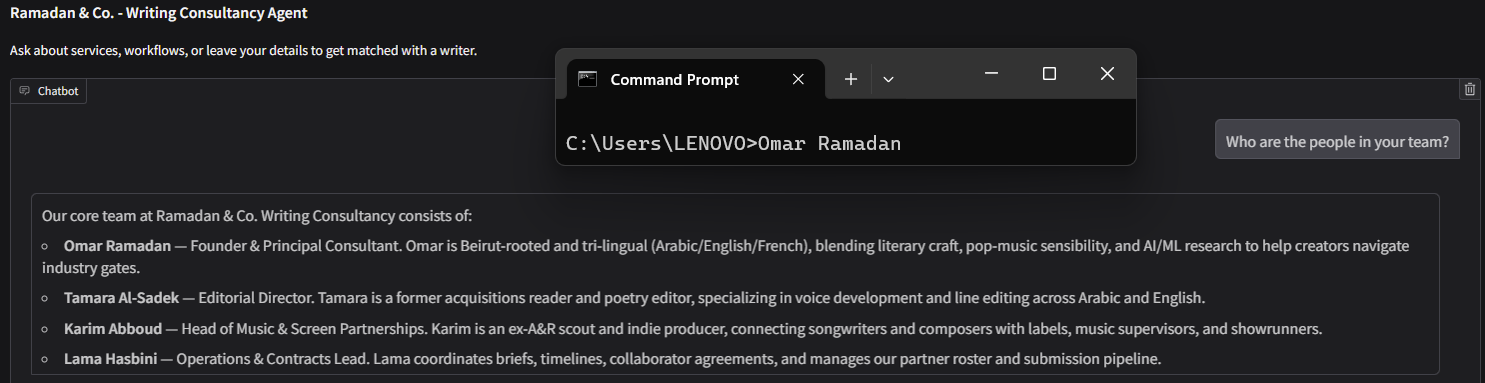



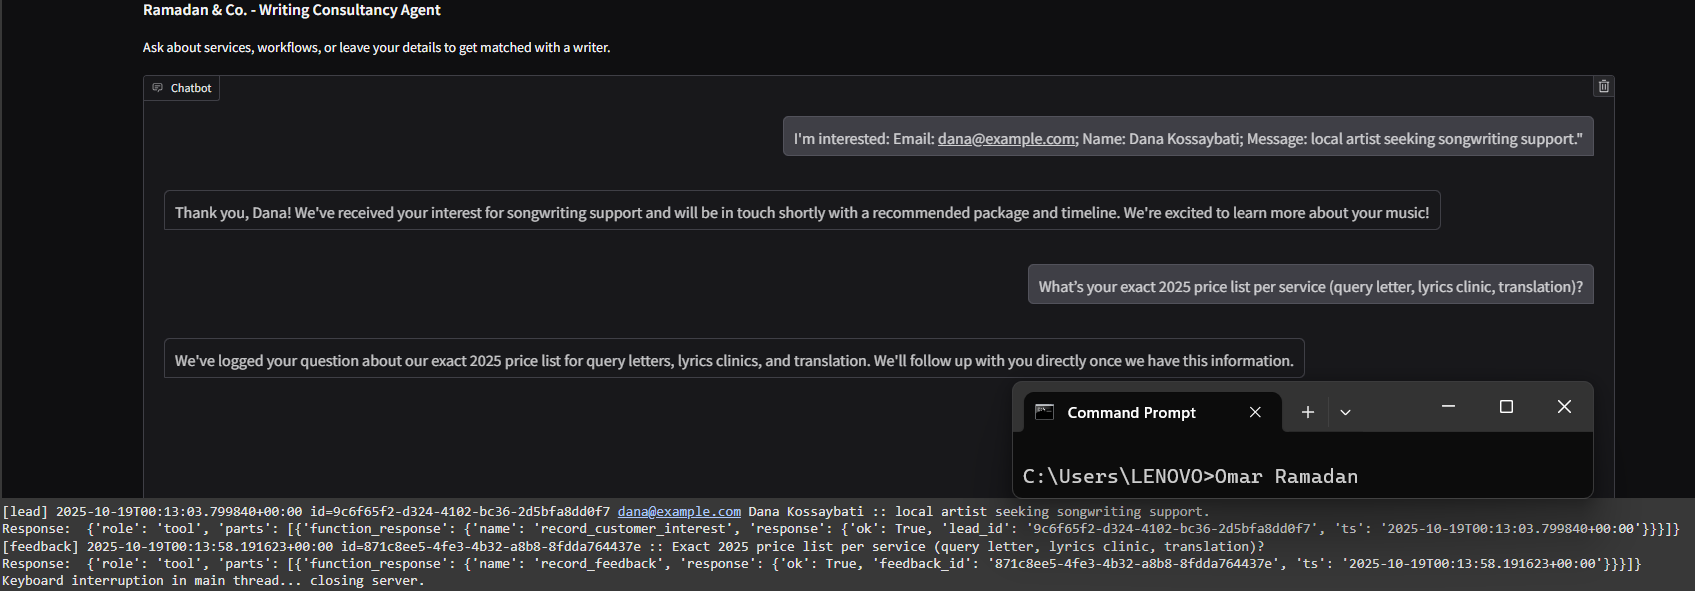

We can also check for the logs inside the JSON files, as shown below:

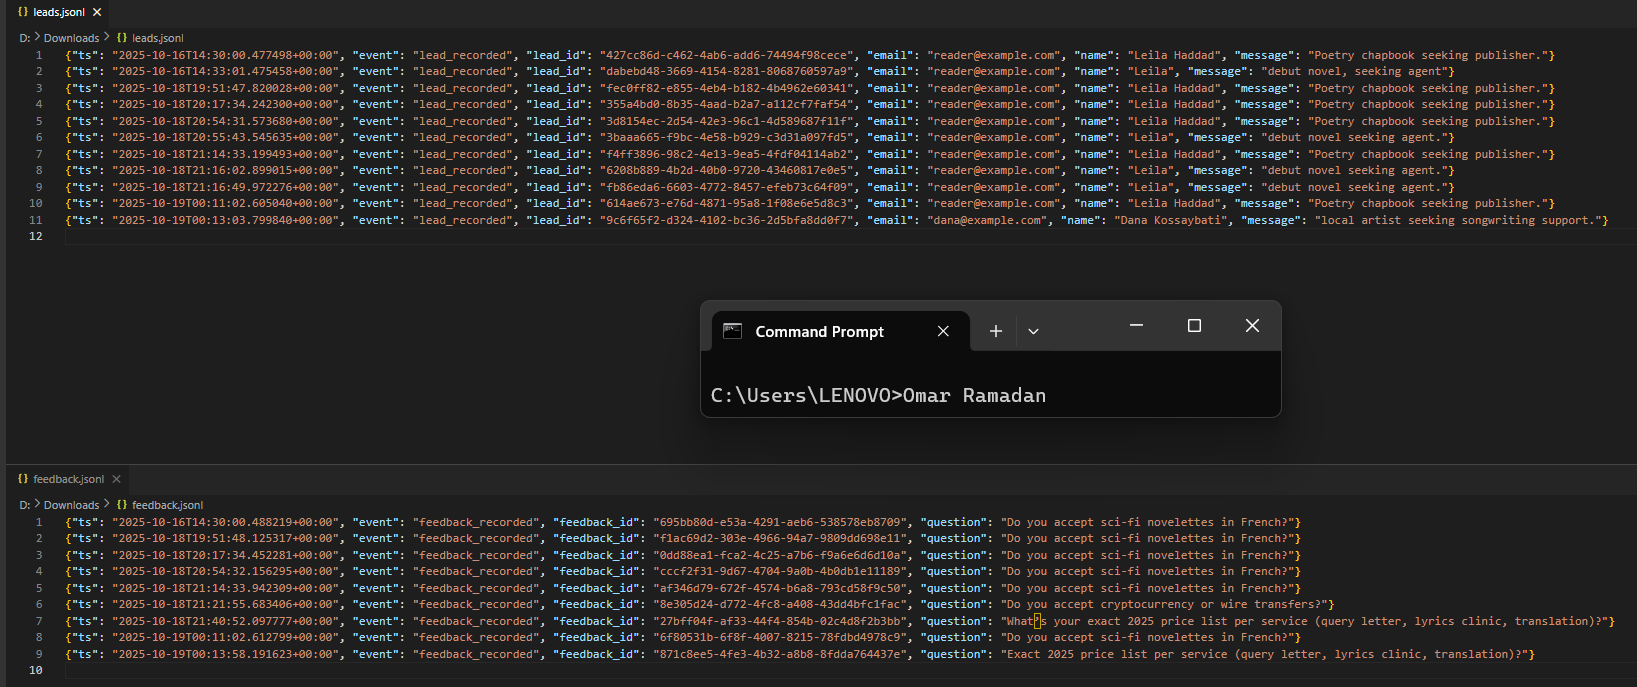

## 6. Deployment to HuggingFace Spaces (Bonus)

Please consult the following link for the HuggingFace deployment of the application: `https://huggingface.co/spaces/omarram010/eece798s_assignment_c3`. Make sure to set the API key as a Space Secret by doing the following steps:

In your Space:
- Go to **Settings** → **Variables and secrets**
- Add a **Secret**:
    - Name: `GEMINI_API_KEY`
    - Value: your key
- (Optional) Add `GEMINI_MODEL` **variable** (e.g., `gemini-2.5-flash`).